# Função de Ativação de Sontag


[Slides Sontag](https://drive.google.com/file/d/1V92dqLg0L3pz5awyvKIavv_FlqtN3Wuz/view)



#

## Referências para treino

https://www.geeksforgeeks.org/extending-pytorch-with-custom-activation-functions/

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [5]:
from random import random, normalvariate
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def funcao_caracteristica(x,y):
    """Define meu conjunto esperado"""
    if abs(x) > 1 or abs(y) > 1:
        return 0
    if abs(y) > 0.8:
        return 1
    raio = x**2 + y**2
    if raio < 0.5 and raio > 0.25:
        return 1
    else:
        return 0

In [3]:

N = 3000
# Dados normais
DADOS = []
for i in range(N):
    x = normalvariate(0, 0.5)
    y = normalvariate(0, 0.5)
    z = funcao_caracteristica(x,y)
    DADOS.append([x,y,z])
    
DADOS = np.array(DADOS)

In [4]:
N = 3000
# Dados uniformes
DADOS = []
for i in range(N):
    K = 2.5
    x = K*(random()-1/2)
    y = K*(random()-1/2)
    z = funcao_caracteristica(x,y)
    DADOS.append([x,y,z])
    
DADOS = np.array(DADOS)

In [5]:
TEST_DADOS = []
for i in range(N//10):
    K = 2.5
    x = K*(random()-1/2)
    y = K*(random()-1/2)
    z = funcao_caracteristica(x,y)
    TEST_DADOS.append([x,y,z])

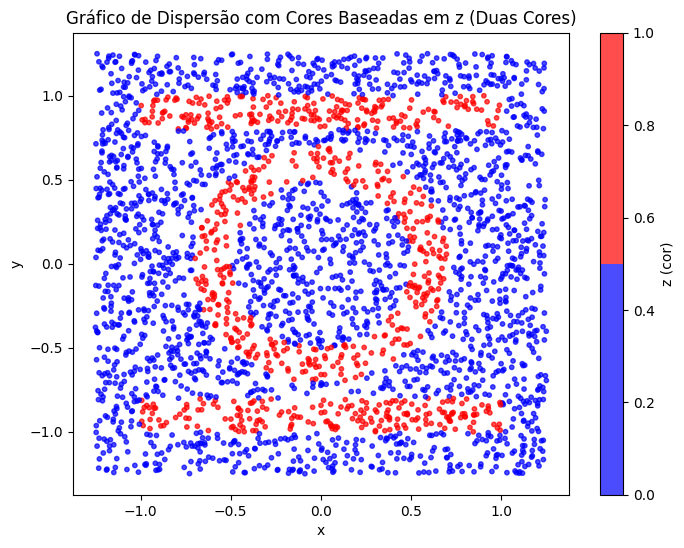

In [6]:
# Definindo um mapa de cores com apenas duas cores (por exemplo, azul e vermelho)
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['blue', 'red'])

x_coords = DADOS[:, 0]
y_coords = DADOS[:, 1]
z_coords = DADOS[:, 2]

# Criando o gráfico de dispersão com o novo mapa de cores
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_coords, y_coords, c=z_coords, cmap=cmap, alpha=0.7, s=10)  # s ajusta o tamanho dos pontos
plt.colorbar(scatter, label='z (cor)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gráfico de Dispersão com Cores Baseadas em z (Duas Cores)')
plt.show()

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


class RedeNeural(nn.Module):
    def __init__(self, hidden_size=10):
        super(RedeNeural, self).__init__()
        self.camada1 = nn.Linear(2, hidden_size)  
        self.camada2 = nn.Linear(hidden_size, 1) 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.camada1(x)
        x = self.relu(x) 
        x = self.camada2(x)
        x = self.sigmoid(x)
        return x

In [8]:
import sys

In [9]:
class MeuDataset(Dataset):
    def __init__(self, dados):
        self.dados = dados

    def __len__(self):
        return len(self.dados)

    def __getitem__(self, idx):
        x = torch.tensor(self.dados[idx][:2], dtype=torch.float32)
        y = torch.tensor(self.dados[idx][2], dtype=torch.float32)
        return x, y

# Dividir os dados em treino e teste

train_dataset = MeuDataset(DADOS)
dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [10]:

# Define the Sontag Sigmoid function
# https://www.geeksforgeeks.org/extending-pytorch-with-custom-activation-functions/
class SigmoideSontag(nn.Module):
    def __init__(self, alpha=100):
        super().__init__()
        self.alpha = alpha
        
    def forward(self, x):
        sigmoid = torch.atanh(x)/np.pi + 0.5 + torch.cos(x)/(self.alpha*(1+torch.pow(x,2)))
        return sigmoid

In [14]:
HIDDEN_SIZE = 300
my_net = RedeNeural(HIDDEN_SIZE)
# Definindo a função de perda e o otimizador
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(my_net.parameters(), lr=0.01)
# Definindo os dados de entrada e saída



# Convertendo os dados para tensores do PyTorch 

# Treinando a rede neural

test_dataset = MeuDataset(TEST_DADOS)

N_EPOCHS = 400
for epoch in range(N_EPOCHS):
    for X, y in dataset_loader:
        # ZERANDO O GRADIENTE
        optimizer.zero_grad()
        # Passando os dados pela rede neural
        outputs = my_net(X)
        # Calculando a perda
        loss = loss_fn(outputs.squeeze(), y)
        # Calculando o gradiente
        loss.backward()
        # Atualizando os pesos
        optimizer.step()
        if epoch % 100 == 0:
            mu = loss.mean()
            sys.stdout.write(f'\rEpoch [{epoch+1}/{N_EPOCHS}], Loss: {mu:.4f}')
            sys.stdout.flush() 
# Testando a rede neural ? 

Epoch [301/400], Loss: 0.0290

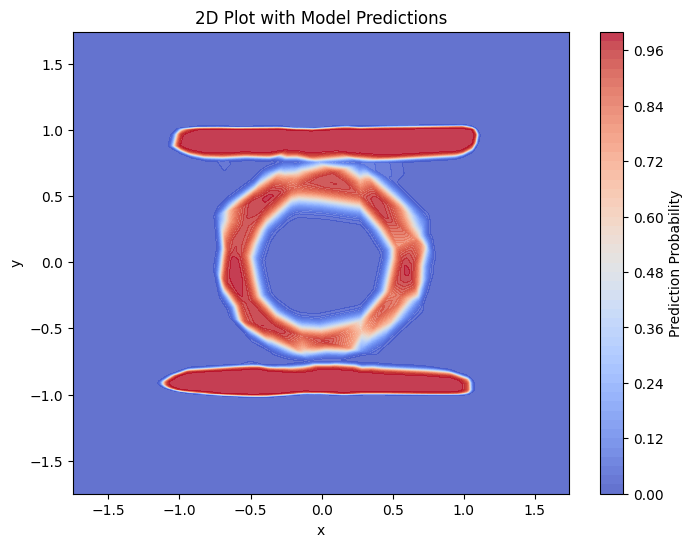

In [13]:
# Create a grid of points
x_min, x_max = DADOS[:, 0].min() - 0.5, DADOS[:, 0].max() + 0.5
y_min, y_max = DADOS[:, 1].min() - 0.5, DADOS[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Prepare the grid points for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Get predictions from the model
with torch.no_grad():
    predictions = my_net(grid_tensor).numpy()

# Reshape predictions to match the grid shape
predictions = predictions.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, predictions, levels=50, cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Prediction Probability')

# Overlay the original data points
#plt.scatter(DADOS[:, 0], DADOS[:, 1], c=DADOS[:, 2], cmap=cmap, edgecolor='k', s=7)
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Plot with Model Predictions')
plt.savefig(f"rede_relu_{HIDDEN_SIZE}.png")
plt.show()

In [2]:
import json

with open(f"metadados_treino.json", "r") as f:
    metadados = json.load(f)

In [3]:
metadados[23]

IndexError: list index out of range

In [6]:
# Iterar sobre cada entrada nos metadados
for entry in metadados:
    model_name = entry['name']
    training_time = entry['time']
    loss_values = entry['loss']
    
    # Criar o gráfico de loss
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(loss_values)), loss_values, label='Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Tempo de Treino: {training_time:.2f}s')
    plt.legend()
    plt.grid(True)
    
    # Salvar o gráfico como imagem
    plt.savefig(f"{model_name} loss.png")
    plt.close()

In [13]:
len(metadados[0]['loss'])//32

1968